In [2]:
import numpy as np

def get_datasets(dataset_cls, batch_size):
    def get_batches(X, y):
        num_batches = len(X) // batch_size
        X_batched = np.array_split(X, num_batches)
        y_batched = np.array_split(y.astype(np.int32), num_batches)
        return X_batched, y_batched

    dataset = dataset_cls()
    X_train = dataset.train_images()
    y_train = dataset.train_labels()
    X_train_batched, y_train_batched = get_batches(X_train, y_train)

    X_test = dataset.test_images()
    y_test = dataset.test_labels()
    X_test_batched, y_test_batched = get_batches(X_test, y_test)
    return X_train_batched, y_train_batched, X_test_batched, y_test_batched

In [3]:
from flax import linen as nn

class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [4]:
import jax
import jax.numpy as jnp

net = NN()
print(net.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                   NN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs           ┃ outputs        ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ NN     │ float32[1,28,28] │ float32[1,10]  │                       │
├─────────┼────────┼──────────────────┼────────────────┼───────────────────────┤
│ Dense_0 │ Dense  │ float32[1,784]   │ float32[1,512] │ bias: float32[512]    │
│         │        │                  │                │ kernel:               │
│         │        │                  │                │ float32[784,512]      │
│         │        │                  │                │                       │
│         │        │                  │                │ 401,920 (1.6 MB)      │
├─────────┼────────┼──────────────────┼────────────────┼───────────────────────┤
│ Dense_1 │ Dense  │ float3

In [5]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [6]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [7]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, optimizer, rng):
    params = module.init(rng, jnp.ones([1, 28, 28]))['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params, tx=optimizer, metrics=Metrics.empty()
    )
    return train_state

In [8]:
@jax.jit
def train_step(state, X, y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [9]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [10]:
import mnists

batch_size = 128

X_train, y_train, X_test, y_test = get_datasets(mnists.FashionMNIST, batch_size)

In [10]:
num_epochs = 100
report_every = 5

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

optimizer = optax.sgd(learning_rate=0.001, momentum=0.9, nesterov=True)
state = create_train_state(net, optimizer, jax.random.key(0))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch)
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   5, [Train] loss: 2.117, accuracy: 0.171, [Test] loss: 2.112, accuracy: 0.175
Epoch:  10, [Train] loss: 1.923, accuracy: 0.238, [Test] loss: 1.878, accuracy: 0.266
Epoch:  15, [Train] loss: 1.603, accuracy: 0.337, [Test] loss: 1.618, accuracy: 0.331
Epoch:  20, [Train] loss: 1.271, accuracy: 0.449, [Test] loss: 1.286, accuracy: 0.451
Epoch:  25, [Train] loss: 1.242, accuracy: 0.457, [Test] loss: 1.270, accuracy: 0.452
Epoch:  30, [Train] loss: 1.231, accuracy: 0.465, [Test] loss: 1.258, accuracy: 0.462
Epoch:  35, [Train] loss: 1.053, accuracy: 0.536, [Test] loss: 1.075, accuracy: 0.546
Epoch:  40, [Train] loss: 1.228, accuracy: 0.467, [Test] loss: 1.204, accuracy: 0.521
Epoch:  45, [Train] loss: 1.549, accuracy: 0.341, [Test] loss: 1.532, accuracy: 0.337
Epoch:  50, [Train] loss: 1.486, accuracy: 0.354, [Test] loss: 1.516, accuracy: 0.318
Epoch:  55, [Train] loss: 2.085, accuracy: 0.196, [Test] loss: 2.072, accuracy: 0.190
Epoch:  60, [Train] loss: 1.895, accuracy: 0.195, [Tes

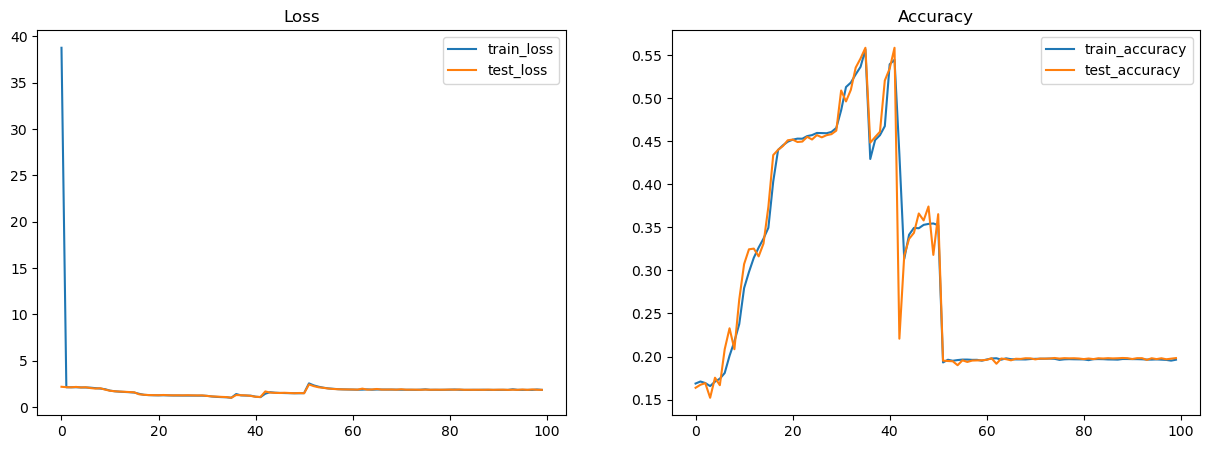

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [13]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [14]:
cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28]  │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,28,28,… │ bias: float32[32] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 320 (1.3 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

In [16]:
num_epochs = 1000
report_every = 5

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

optimizer = optax.sgd(learning_rate=0.001, momentum=0.9, nesterov=True)
# optimizer = optax.adam(learning_rate=0.001)#, momentum=0.9, nesterov=True)
state = create_train_state(cnn, optimizer, jax.random.key(0))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch)
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   5, [Train] loss: 0.205, accuracy: 0.929, [Test] loss: 0.285, accuracy: 0.899
Epoch:  10, [Train] loss: 0.146, accuracy: 0.951, [Test] loss: 0.277, accuracy: 0.905
Epoch:  15, [Train] loss: 0.102, accuracy: 0.968, [Test] loss: 0.289, accuracy: 0.908
Epoch:  20, [Train] loss: 0.068, accuracy: 0.982, [Test] loss: 0.316, accuracy: 0.909
Epoch:  25, [Train] loss: 0.042, accuracy: 0.991, [Test] loss: 0.353, accuracy: 0.908
Epoch:  30, [Train] loss: 0.026, accuracy: 0.996, [Test] loss: 0.416, accuracy: 0.904
Epoch:  35, [Train] loss: 0.018, accuracy: 0.998, [Test] loss: 0.476, accuracy: 0.903
Epoch:  40, [Train] loss: 0.013, accuracy: 0.999, [Test] loss: 0.551, accuracy: 0.904
Epoch:  45, [Train] loss: 0.009, accuracy: 1.000, [Test] loss: 0.600, accuracy: 0.904
Epoch:  50, [Train] loss: 0.006, accuracy: 1.000, [Test] loss: 0.539, accuracy: 0.914
Epoch:  55, [Train] loss: 0.005, accuracy: 1.000, [Test] loss: 0.596, accuracy: 0.911
Epoch:  60, [Train] loss: 0.003, accuracy: 1.000, [Tes

KeyboardInterrupt: 

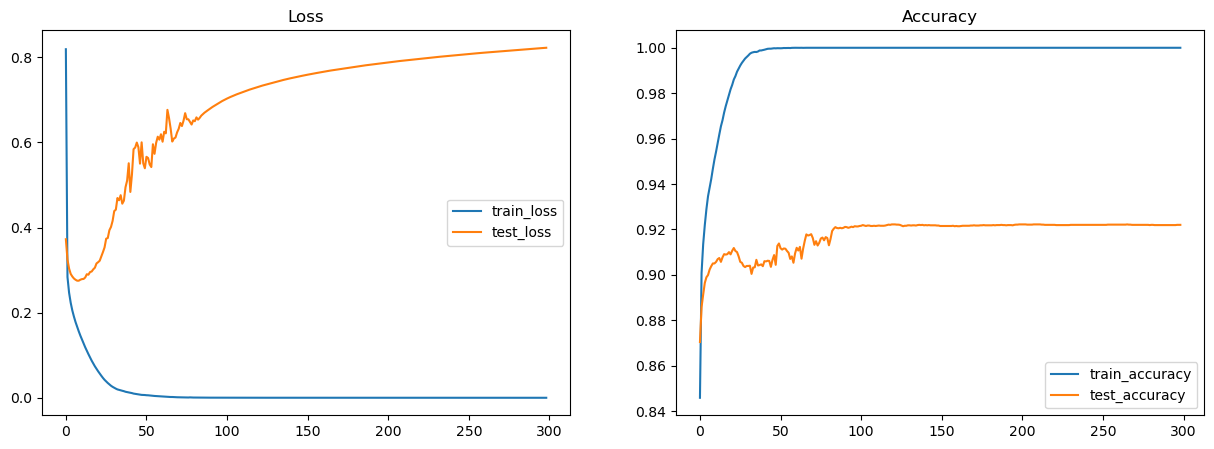

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [11]:
class CNNDropout(nn.Module):
    @nn.compact
    def __call__(self, x, training: bool):
        x = x[..., None]
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=10)(x)
        return x

cnnd = CNNDropout()

In [12]:
print(cnnd.tabulate(jax.random.key(0), jnp.ones((1, 28, 28)), training=False))


                               CNNDropout Summary                               
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module     ┃ inputs          ┃ outputs         ┃ params          ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│           │ CNNDropout │ -               │ float32[1,10]   │                 │
│           │            │ float32[1,28,2… │                 │                 │
│           │            │ - training:     │                 │                 │
│           │            │ False           │                 │                 │
├───────────┼────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Conv_0    │ Conv       │ float32[1,28,2… │ float32[1,28,2… │ bias:           │
│           │            │                 │                 │ float32[32]     │
│           │            │                 │                 │ kernel:         │
│           │            │ 

In [13]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.Array

def create_train_state(module, optimizer, rng, dropout_key):
    params = module.init(rng, jnp.ones([1, 28, 28]), training=False)['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params, tx=optimizer, metrics=Metrics.empty(), key=dropout_key
    )
    return train_state

In [14]:
@jax.jit
def train_step(state, X, y, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X, training=True, rngs={'dropout': dropout_train_key})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [15]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X, training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [18]:
num_epochs = 1000
report_every = 5

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

# optimizer = optax.sgd(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = optax.adam(learning_rate=0.001)
state = create_train_state(cnnd, optimizer, jax.random.key(0), jax.random.key(1))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch, jax.random.key(2))
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   5, [Train] loss: 0.732, accuracy: 0.708, [Test] loss: 0.740, accuracy: 0.698
Epoch:  10, [Train] loss: 0.601, accuracy: 0.744, [Test] loss: 0.615, accuracy: 0.736
Epoch:  15, [Train] loss: 0.630, accuracy: 0.737, [Test] loss: 0.652, accuracy: 0.733
Epoch:  20, [Train] loss: 0.627, accuracy: 0.741, [Test] loss: 0.643, accuracy: 0.767
Epoch:  25, [Train] loss: 0.710, accuracy: 0.727, [Test] loss: 0.698, accuracy: 0.743
Epoch:  30, [Train] loss: 0.719, accuracy: 0.720, [Test] loss: 0.720, accuracy: 0.713
Epoch:  35, [Train] loss: 0.709, accuracy: 0.720, [Test] loss: 0.918, accuracy: 0.704
Epoch:  40, [Train] loss: 0.967, accuracy: 0.658, [Test] loss: 1.128, accuracy: 0.644
Epoch:  45, [Train] loss: 1.483, accuracy: 0.366, [Test] loss: 1.533, accuracy: 0.337
Epoch:  50, [Train] loss: 2.148, accuracy: 0.149, [Test] loss: 2.114, accuracy: 0.173


KeyboardInterrupt: 

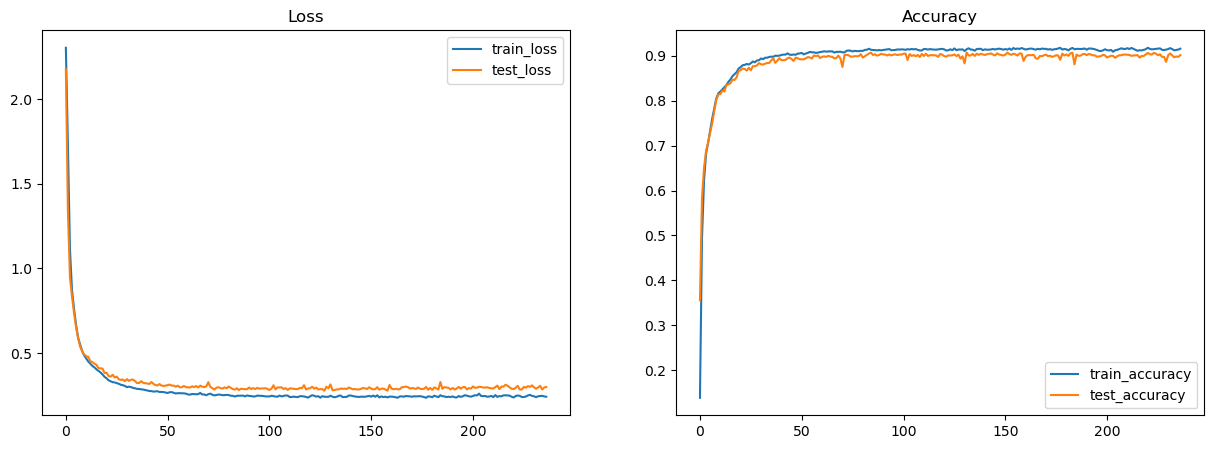

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [39]:
class ResBlock(nn.Module):
    @nn.compact
    def __call__(self, x):
        x1 = x
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        return x + x1

class Resnet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]

        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=1024)(x)

        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)

        x = nn.Dense(features=10)(x)
        return x

resnet = Resnet()

In [40]:
print(resnet.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                 Resnet Summary                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module   ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ Resnet   │ float32[1,28,… │ float32[1,10]  │                │
├────────────────┼──────────┼────────────────┼────────────────┼────────────────┤
│ Conv_0         │ Conv     │ float32[1,28,… │ float32[1,28,… │ bias:          │
│                │          │                │                │ float32[32]    │
│                │          │                │                │ kernel:        │
│                │          │                │                │ float32[3,3,1… │
│                │          │                │                │                │
│                │          │                │                │ 320 (1.3 KB)   │
├────────────────┼─────────

In [41]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [42]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, optimizer, rng):
    params = module.init(rng, jnp.ones([1, 28, 28]))['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params, tx=optimizer, metrics=Metrics.empty()
    )
    return train_state

In [43]:
@jax.jit
def train_step(state, X, y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [44]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [48]:
num_epochs = 1000
report_every = 1

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

optimizer = optax.sgd(learning_rate=0.0001, momentum=0.9, nesterov=True)
# optimizer = optax.adam(learning_rate=0.001)#, momentum=0.9, nesterov=True)
state = create_train_state(resnet, optimizer, jax.random.key(0))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch)
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   1, [Train] loss: 5.248, accuracy: 0.278, [Test] loss: 1.864, accuracy: 0.391
Epoch:   2, [Train] loss: 1.765, accuracy: 0.429, [Test] loss: 1.716, accuracy: 0.458
Epoch:   3, [Train] loss: 1.637, accuracy: 0.481, [Test] loss: 1.597, accuracy: 0.499
Epoch:   4, [Train] loss: 1.523, accuracy: 0.516, [Test] loss: 1.481, accuracy: 0.530
Epoch:   5, [Train] loss: 1.412, accuracy: 0.550, [Test] loss: 1.369, accuracy: 0.565
Epoch:   6, [Train] loss: 1.303, accuracy: 0.615, [Test] loss: 1.256, accuracy: 0.645
Epoch:   7, [Train] loss: 1.181, accuracy: 0.670, [Test] loss: 1.114, accuracy: 0.686
Epoch:   8, [Train] loss: 1.019, accuracy: 0.707, [Test] loss: 0.938, accuracy: 0.725
Epoch:   9, [Train] loss: 0.836, accuracy: 0.749, [Test] loss: 0.778, accuracy: 0.757
Epoch:  10, [Train] loss: 0.692, accuracy: 0.781, [Test] loss: 0.664, accuracy: 0.786
Epoch:  11, [Train] loss: 0.589, accuracy: 0.804, [Test] loss: 0.584, accuracy: 0.803
Epoch:  12, [Train] loss: 0.522, accuracy: 0.820, [Tes

KeyboardInterrupt: 